In [220]:
import numpy as np
import cPickle
import os
import gzip
import matplotlib.pyplot as plt

# First exercise: Classifying MNIST with MLPs

In this exercise Neural Network (MLP) for MNIST digits classification is implemented. MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading

We first define a function for downloading and loading MNIST.

In [221]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

# Neural Network Layers

We now define "bare bone" neural network layers.
Conceptually we will implement the layers as follows:

Each layer has a constructor that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): output_shape(), fprop() and brop(). The output_shape function is used to figure out the shape for the next layer and the fprop()/bprop() functions are used to compute forward and backward passes through the network.

In [222]:
# start by defining simple helpers
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def sigmoid_d(x):
    #################
    # Derivative of sigmoid f-n
    #################
    return sigmoid(x)*(1.0 - sigmoid(x)) 

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    #################
    # Derivative of hyperbolic tangent
    #################
    return 1.0 - np.power(tanh(x), 2)

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    #################
    # ReLU derivative
    #################
    x[x<0] = 0
    x[x>0] = 1
    return x
    

def softmax(x, axis=1):
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max
    e_x = np.exp(x_safe)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    return np.argmax(one_hot_labels, axis=-1)

# then define an activation function class
class Activation(object):
    
    def __init__(self, tname):
        if tname == 'sigmoid':
            self.act = sigmoid
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')
            
    def fprop(self, input):
        # we need to remember the last input
        # so that we can calculate the derivative with respect
        # to it later on
        self.last_input = input
        return self.act(input)
    
    def bprop(self, output_grad):
        return output_grad * self.act_d(self.last_input)
    
# define a base class for layers
class Layer(object):
    
    def fprop(self, input):
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')
        
# define a base class for loss outputs
# an output layer can then simply be derived
# from both Layer and Loss 
class Loss(object):

    def loss(self, output, output_net):
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')
        
# define a base class for parameterized things        
class Parameterized(object):
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')
        
# define a container for providing input to the network
class InputLayer(Layer):
    
    def __init__(self, input_shape):
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input):
        return input
    
    def bprop(self, output_grad):
        return output_grad
    
class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """
    
    def __init__(self, input_layer, num_units, 
                 init_stddev, activation_fun=Activation('relu')):
        self.num_units = num_units
        self.activation_fun = activation_fun
        # the input shape will be of size (batch_size, num_units_prev) 
        # where num_units_prev is the number of units in the input 
        # (previous) layer
        self.input_shape = input_layer.output_size()
        #################################
        #  implement weight initialization
        #################################
        # this is the weight matrix it should have shape: (num_units_prev, num_units)
        
        #initializing W with random noise (using normal distribution with changing std)
        num_units_prev = self.input_shape[1]
        self.W = np.random.normal(loc=0.0, scale=init_stddev, size=(num_units_prev, self.num_units))
        # and this is the bias vector of shape: (num_units)
        #initializing bias vector with zeros (common practice)
        
        self.b = np.zeros(self.num_units)
        # create dummy variables for parameter gradients
        # no need to change these here!
        self.dW = None
        self.db = None
    
    def output_size(self):
        return (self.input_shape[0], self.num_units)
    
    def fprop(self, input):
        # ################################################
        #  implement forward propagation
        # NOTE: you should also handle the case were 
        #       activation_fun is None (meaning no activation)
        #       then this is simply a linear layer
        # ################################################
        # you again want to cache the last_input for the bprop
        # implementation below!
        self.last_input = input
        output_act = np.dot(input, self.W) + self.b
        if self.activation_fun is not None:
            output_act = self.activation_fun.fprop(output_act)
        return output_act
        
        
        
    def bprop(self, output_grad):
        """ Calculate input gradient (backpropagation). """
        # ################################
        #  implement backward propagation
        # ###############################
        
        # HINT: you may have to divide dW and db by n
        #       to make gradient checking work 
        #       OR you divide the gradient in the output layer by n
        n = output_grad.shape[0]
        # accumulate gradient wrt. the parameters first
        # we will need to store these to later update
        # the network after a few forward backward passes
        # the gradient wrt. W should be stored as self.dW
        # the gradient wrt. b should be stored as selfdb
        if self.activation_fun is not None:
            grad_act = self.activation_fun.bprop(output_grad)
        else:
            grad_act = output_grad
        self.dW = np.dot(self.last_input.T, grad_act)/n
        self.db = np.mean(grad_act, axis = 0)
        # the gradient wrt. the input 
        grad_input = np.dot(grad_act, self.W.T)
        return grad_input
        
    def params(self):
        return self.W, self.b

    def grad_params(self):
        return self.dW, self.db

# finally we specify the interface for output layers 
# which are layers that also have a loss function
# we will implement two output layers:
#  a Linear, and Softmax (Logistic Regression) layer
# The difference between output layers and and normal 
# layers is that they will be called to compute the gradient
# of the loss through input_grad(). bprop will never 
# be called on them!
class LinearOutput(Layer, Loss):
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
        
    def fprop(self, input):
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        #####################################
        # implement gradient of squared loss
        #####################################
        return -(Y - Y_pred)

    def loss(self, Y, Y_pred):
        loss = 0.5 * np.square(Y_pred - Y)
        return np.mean(np.sum(loss, axis=1))
    
class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
    
    def fprop(self, input):
        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):
        ########################################################
        #  implement gradient of the negative log likelihood loss
        ########################################################
        # HINT: since this would involve taking the log 
        #       of the softmax (which is np.exp(x)/np.sum(x, axis=1))
        #       this gradient computation can be simplified a lot! 
        return -(Y - Y_pred)

    def loss(self, Y, Y_pred):
        # Assume one-hot encoding of Y
        out = Y_pred
        # to make the loss numerically stable 
        # you may want to add an epsilon in the log ;)
        eps = 1e-10
        #####################################
        # calculate negative log likelihood
        #####################################
        loss = -np.sum(Y * np.log(Y_pred + eps))/ Y.shape[0]
        return loss

# Neural Network class

With all layers in place we can finally define a neural network. 
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the check_gradients() function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [312]:
class NeuralNetwork:
    """ Our Neural Network container class.
    """
    def __init__(self, layers):
        self.layers = layers
        
    def _loss(self, X, Y):
        Y_pred = self.predict(X)
        return self.layers[-1].loss(Y, Y_pred)

    def predict(self, X):
        """ Calculate an output Y for the given input X. """
        ###########################################
        #  implement forward pass through all layers
        ###########################################
        Y_pred = X
        for layer in self.layers:
            Y_pred = layer.fprop(Y_pred)
        return Y_pred
    
    def backpropagate(self, Y, Y_pred, upto=0):
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        next_grad = self.layers[-1].input_grad(Y, Y_pred)
        ###########################################
        #  implement backward pass through all layers
        ###########################################
        layer_seq = reversed(self.layers[upto:-1])
        for layer in layer_seq:
            next_grad = layer.bprop(next_grad)
        return next_grad
    
    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))
        error = Y_pred != Y
        return np.mean(error)
    
    def sgd_epoch(self, X, Y, learning_rate, batch_size):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        for b in range(n_batches):
            # #####################################
            # Implement stochastic gradient descent here
            # #####################################
            # start by extracting a batch from X and Y
            # (you can assume the inputs are already shuffled)
            batch_start = b*batch_size
            batch_end = batch_start + batch_size
            X_batch = X[batch_start:batch_end]
            Y_batch = Y[batch_start:batch_end]
            # : then forward and backward propagation + updates
            # HINT: layer.params() returns parameters *by reference*
            #       so you can easily update in-place
            Y_pred = self.predict(X_batch) #forward
            self.backpropagate(Y_batch, Y_pred) #backward
            
            #updates
            for layer in self.layers:
                if isinstance(layer, Parameterized):
                    W, b = layer.params()
                    dW, db = layer.grad_params()
                    W -= learning_rate*dW
                    b -= learning_rate*db
                    
    def gd_epoch(self, X, Y):
        # ##################################################
        # Implement batch gradient descent here
        # A few hints:
        #   There are two strategies you can follow:
        #   Either shove the whole dataset throught the network
        #   at once (which can be problematic for large datasets)
        #   or run through it batch wise as in the sgd approach
        #   and accumulate the gradients for all parameters as
        #   you go through the data. Either way you should then
        #   do one gradient step after you went through the
        #   complete dataset!
        # ##################################################
        return self.sgd_epoch(X, Y, learning_rate, X.shape[0])
    
    def train(self, X, Y, X_valid, Y_valid, learning_rate=0.1, max_epochs=100, batch_size=64,
              descent_type="sgd", y_one_hot=True):

        """ Train network on the given data. """
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size
        if y_one_hot:
            Y_train = one_hot(Y)
        else:
            Y_train = Y
        print("... starting training")
        valid_errs = []
        train_errs = []
        loss = []
        for e in range(max_epochs+1):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))

            # Output error on the training data
            train_loss = self._loss(X, Y_train)
            loss.append(train_loss)
            train_error = self.classification_error(X, Y)
            train_errs.append(train_error*100)
            print('epoch {:.4f}, loss {:.4f}, train error {:.4f}'.format(e, train_loss, train_error))
            # ##################################################
            # compute error on validation data:
            # simply make the function take validation data as input
            # and then compute errors here and print them
            ###################################################
            valid_err = np.zeros(max_epochs + 1)
            
            if (X_valid is not None):
                valid_err = self.classification_error(X_valid, Y_valid)
                print('validation error {:.4f}'.format(valid_err))
            valid_errs.append(valid_err*100)
        epochs = np.arange(0, max_epochs+1, 1)
        
        plt.plot(epochs, train_errs, 'g', valid_errs, 'b') 
        plt.xlabel("epochs")
        plt.ylabel("error, %")
        plt.legend(["training error", "validation error"])
        plt.show()
        fig = plt.figure()
        plt.plot(epochs, loss)
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.show()
        #plt.savefig('errors.jpg')
        return train_error, valid_err
    
    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):
                    # we iterate through all parameters
                    param_shape = param.shape
                    # define functions for conveniently swapping
                    # out parameters of this specific layer and 
                    # computing loss and gradient with these 
                    # changed parametrs
                    def output_given_params(param_new):
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # return computed loss
                        return self._loss(X, Y)

                    def grad_given_params(param_new):
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # copy provided parameters
                        param[:] = np.reshape(param_new, param_shape)
                        # Forward propagation through the net
                        Y_pred = self.predict(X)
                        # Backpropagation of partial derivatives
                        self.backpropagate(Y, Y_pred, upto=l)
                        # return the computed gradient 
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))
                    
                    # ####################################
                    # Tcompute the gradient with respect to the initial parameters in two ways:
                    #      1) with grad_given_params()
                    #      2) with finite differences 
                    #         using output_given_params()
                    #         (as discussed in the lecture)
                    #      if your implementation is correct 
                    #      both results should be epsilon close
                    #      to each other!
                    #####################################
                    epsilon = 1e-4
                    
                    # making sure your gradient checking routine itself 
                    # has no errors can be a bit tricky. To debug it
                    # you can "cheat" by using scipy which implements
                    # gradient checking exactly the way you should!
                    # To do that simply run the following here:
                    #import scipy.optimize
                    #scipy_err = scipy.optimize.check_grad(output_given_params, 
                    #                                grad_given_params, param_init)
                    # print('sci_err  {:.2e}'.format(err))
                    loss_base = output_given_params(param_init)
                    #this should hold the gradient as calculated through bprop
                    gparam_bprop = grad_given_params(param_init)
                    #this should hold the gradient calculated through 
                    #      finite differences
                    gparam_fd = np.zeros_like(param_init)
                    epsilons = np.zeros_like(param_init) #vector for param_init modification
                    for i in range(len(param_init)):
                        epsilons[i] = epsilon 
                        gparam_fd[i] = (output_given_params(param_init + epsilons) - output_given_params(param_init - epsilons))/(2*epsilon)
                        epsilons[i] = 0
                       
                    # calculate difference between them
                    err = np.mean(np.abs(gparam_bprop - gparam_fd))
                    #print err
                    #print epsilon
                    print('diff {:.2e}'.format(err))
                    assert(err < epsilon)
                    
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)
            

# Gradient Checking

After implementing everything it is always a good idea to setup some layers and perform gradient checking on random data. Note that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [313]:
input_shape = (5, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=6,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [314]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [315]:
nn.check_gradients(X, Y)

checking gradient for layer 1
diff 4.60e-12
diff 3.58e-12
checking gradient for layer 2
diff 1.07e-11
diff 9.59e-11
checking gradient for layer 3
diff 4.09e-12
diff 1.14e-10


# Training on MNIST

Finally we can let our network run on the MNIST dataset!
First load the data and reshape it.

In [374]:
# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval
# Downsample training data to make it a bit faster for testing this code
n_train_samples = 40000
train_idxs = np.random.permutation(X_train.shape[0])[:n_train_samples]
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]

... loading data
... done loading data


Dtrain contains 50k images which are of size 28 x 28 pixels. Hence:

In [375]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))

X_train shape: (40000L, 1L, 28L, 28L)
y_train shape: (40000L,)


y_train will automatically be converted in the train() function to one_hot encoding.
But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [376]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape((X_valid.shape[0], -1))
print("Reshaped X_valid size: {}".format(X_valid.shape))

Reshaped X_train size: (40000L, 784L)
Reshaped X_valid size: (10000L, 784L)


Reshaped X_train size: (10000, 784)
Reshaped X_valid size: (10000, 784)
Ah, much better ;-)!

Now we can finally really start training a Network!

40000
... starting training
epoch 0.0000, loss 0.3729, train error 0.1094
validation error 0.1020
epoch 1.0000, loss 0.2230, train error 0.0649
validation error 0.0635
epoch 2.0000, loss 0.1512, train error 0.0445
validation error 0.0446
epoch 3.0000, loss 0.1127, train error 0.0325
validation error 0.0356
epoch 4.0000, loss 0.0877, train error 0.0247
validation error 0.0318
epoch 5.0000, loss 0.0696, train error 0.0192
validation error 0.0298
epoch 6.0000, loss 0.0558, train error 0.0154
validation error 0.0275
epoch 7.0000, loss 0.0455, train error 0.0124
validation error 0.0255
epoch 8.0000, loss 0.0376, train error 0.0101
validation error 0.0244
epoch 9.0000, loss 0.0313, train error 0.0082
validation error 0.0235
epoch 10.0000, loss 0.0265, train error 0.0069
validation error 0.0231
epoch 11.0000, loss 0.0223, train error 0.0056
validation error 0.0231
epoch 12.0000, loss 0.0188, train error 0.0044
validation error 0.0224
epoch 13.0000, loss 0.0159, train error 0.0034
validation e

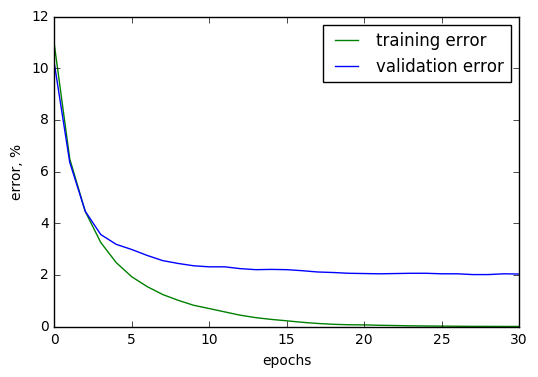

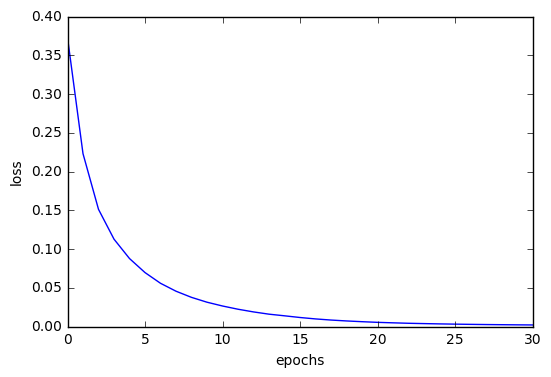

Duration: 201.2s


In [468]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=512,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=256,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10, #amount of classes
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
print X_train.shape[0]
# Train neural network
t0 = time.time()
nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.2, 
         max_epochs=30, batch_size=128, descent_type="sgd", y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))



# Figure out a reasonable Network that achieves good performance

As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the validation set. Train this network on the complete data and compute the test error.


In [469]:
X_t, Y_test = Dtest
X_test = X_t.reshape(X_t.shape[0], -1)
Y_pred = unhot(nn.predict(X_test))
test_error = nn.classification_error(X_test, Y_test)

print('test error {:.4f}'.format(test_error))
print('Duration: {:.1f}s'.format(t1-t0))


test error 0.0206
Duration: 201.2s


Once you have done this, visualize a few digits from the the test set that the network gets right as well as a few that the network gets wrong!

[4674 7603 9452 4100]


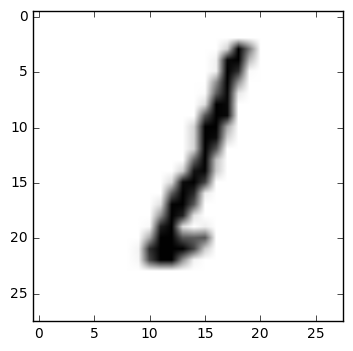

Predicted label 1


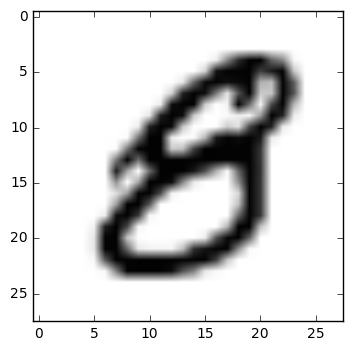

Predicted label 8


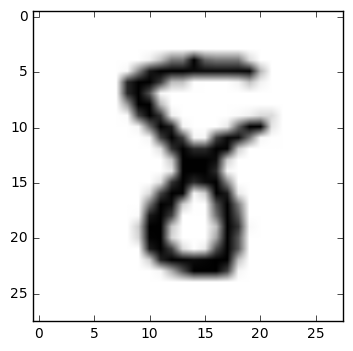

Predicted label 8


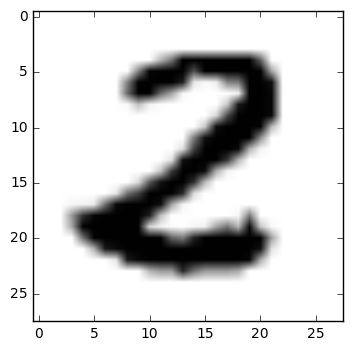

Predicted label 2


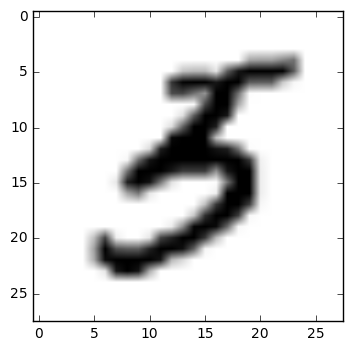

Predicted label:  3 Correct:  5


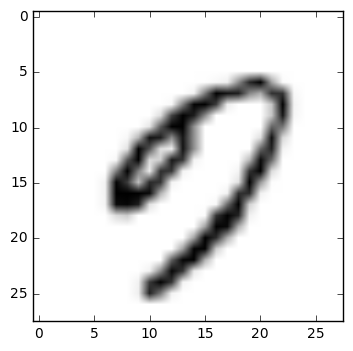

Predicted label:  0 Correct:  9


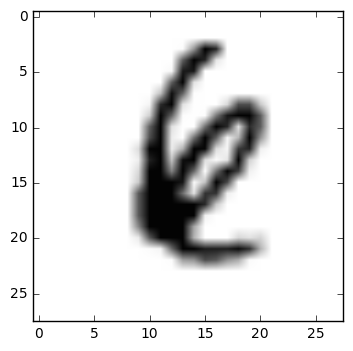

Predicted label:  8 Correct:  6


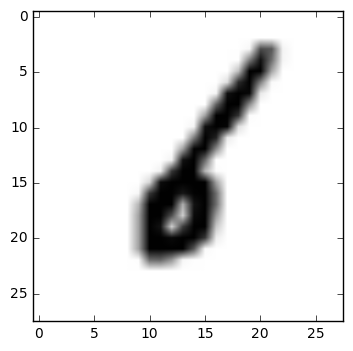

Predicted label:  1 Correct:  6


In [470]:
correct = []
wrong = []

for i in range(len(Y_pred)):
    if (Y_pred[i] != Y_test[i]):
        wrong.append(i)
    else:
        correct.append(i)

correct_img = np.random.choice(correct, 4)
print correct_img
wrong_img = np.random.choice(wrong, 4)

fig_01 = plt.figure()


for i in correct_img:
    img = X_test[i, :].reshape((28, 28))
    plt.imshow(img, cmap='Greys',)
    plt.show()
    print "Predicted label", Y_pred[i]
    
        
        
 

fig_02 = plt.figure()
for i in wrong_img:
    img = X_test[i, :].reshape((28, 28))
    plt.imshow(img, cmap='Greys')
    plt.show()
    print "Predicted label: ", Y_pred[i], "Correct: ", Y_test[i]


# Setting Network

... starting training
epoch 0.0000, loss 2.3007, train error 0.8865
validation error 0.8936
epoch 1.0000, loss 2.2978, train error 0.8865
validation error 0.8936
epoch 2.0000, loss 2.5181, train error 0.8998
validation error 0.9024
epoch 3.0000, loss 1.1810, train error 0.4550
validation error 0.4413
epoch 4.0000, loss 0.8418, train error 0.3068
validation error 0.2832
epoch 5.0000, loss 0.8317, train error 0.2847
validation error 0.2804
epoch 6.0000, loss 0.5926, train error 0.1880
validation error 0.1830
epoch 7.0000, loss 0.4291, train error 0.1323
validation error 0.1314
epoch 8.0000, loss 0.3744, train error 0.1162
validation error 0.1151
epoch 9.0000, loss 0.3423, train error 0.1074
validation error 0.1037
epoch 10.0000, loss 0.3166, train error 0.0995
validation error 0.0969
epoch 11.0000, loss 0.2954, train error 0.0929
validation error 0.0908
epoch 12.0000, loss 0.2798, train error 0.0891
validation error 0.0865
epoch 13.0000, loss 0.2688, train error 0.0858
validation error 0

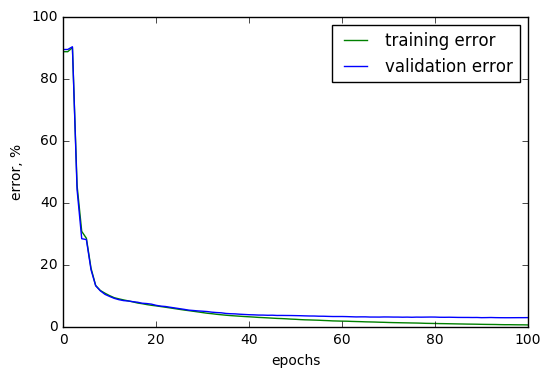

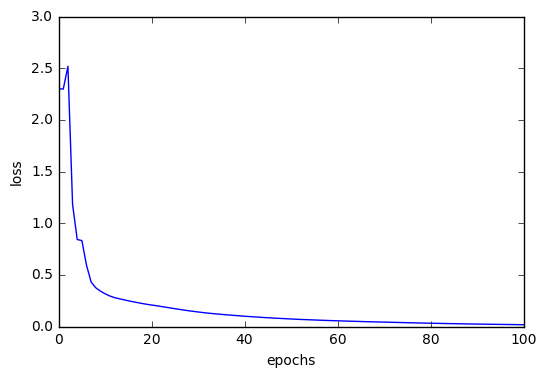

Training and Validation Duration: 1989.9s
test error: 0.0318
test loss: 0.1276
Duration: 2.5s


In [464]:
import time
# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (40000, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=1028,
                init_stddev=0.01,
                activation_fun=Activation('sigmoid')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=512,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=128,
                init_stddev=0.01,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,
                init_stddev=0.01,
                # last layer has no nonlinearity
                # (softmax will be applied in the output layer)
                activation_fun=None
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.15,
         max_epochs=100, batch_size=128, descent_type="sgd", y_one_hot=True)
t1 = time.time()
print('Training and Validation Duration: {:.1f}s'.format(t1-t0))

#test
t0 = time.time()
X_t, Y_test = Dtest
X_test = X_t.reshape(X_t.shape[0], -1)
Y_pred = unhot(nn.predict(X_test))
test_error = nn.classification_error(X_test, Y_test)
test_loss = nn._loss(X_test, one_hot(Y_test))
print('test error: {:.4f}'.format(test_error))
print('test loss: {:.4f}'.format(test_loss))
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))